# Visualization of Spotify songs data

In [40]:
import pandas as pd
import plotly.express as plte
import seaborn as sb

from matplotlib import pyplot as plt
from google.colab import drive

Mount my drive into Google Colab in order to load the dataset from the data directory

In [31]:
drive.mount('my_drive')

Drive already mounted at my_drive; to attempt to forcibly remount, call drive.mount("my_drive", force_remount=True).


In [32]:
data_directory = 'my_drive/MyDrive/2_Informatica/2_Facultate/2_Master/Anul_II/Sem_II/3_Data_Visualization/3_Proiect/dataset/'

The initial data has a column called *duration_ms* which represents the duration of a song in miliseconds, for a better understanding we will convert the duration to seconds

In [33]:
def convert_ms_to_seconds(nr_ms):
    return nr_ms // 1000

In [34]:
data = pd.read_csv(f'{data_directory}data.csv')
data['duration_ms'] = data['duration_ms'].apply(convert_ms_to_seconds)
data.rename(columns={'duration_ms': 'duration_seconds'}, inplace=True)

We are interested to see how the total number of released songs per year is changing from 1921 to 2020

In [35]:
nr_songs_per_year = {}
for song_year in data['year']:
    if song_year in nr_songs_per_year:
        nr_songs_per_year[song_year] += 1
    else:
        nr_songs_per_year[song_year] = 1

nr_songs_per_year_df = pd.DataFrame(columns=['year', 'nr_songs_released'])
for year in nr_songs_per_year:
    nr_songs_per_year_df = nr_songs_per_year_df.append(
        {'year': year, 'nr_songs_released': nr_songs_per_year[year]},
        ignore_index=True
    )

In [36]:
fig_nr_songs_per_year = plte.bar(
    nr_songs_per_year_df,
    x='year',
    y='nr_songs_released',
    color='nr_songs_released'
)
fig_nr_songs_per_year.show()

In order to visualize the above plotly plot into GitHub, a screenshot of the plot is attached: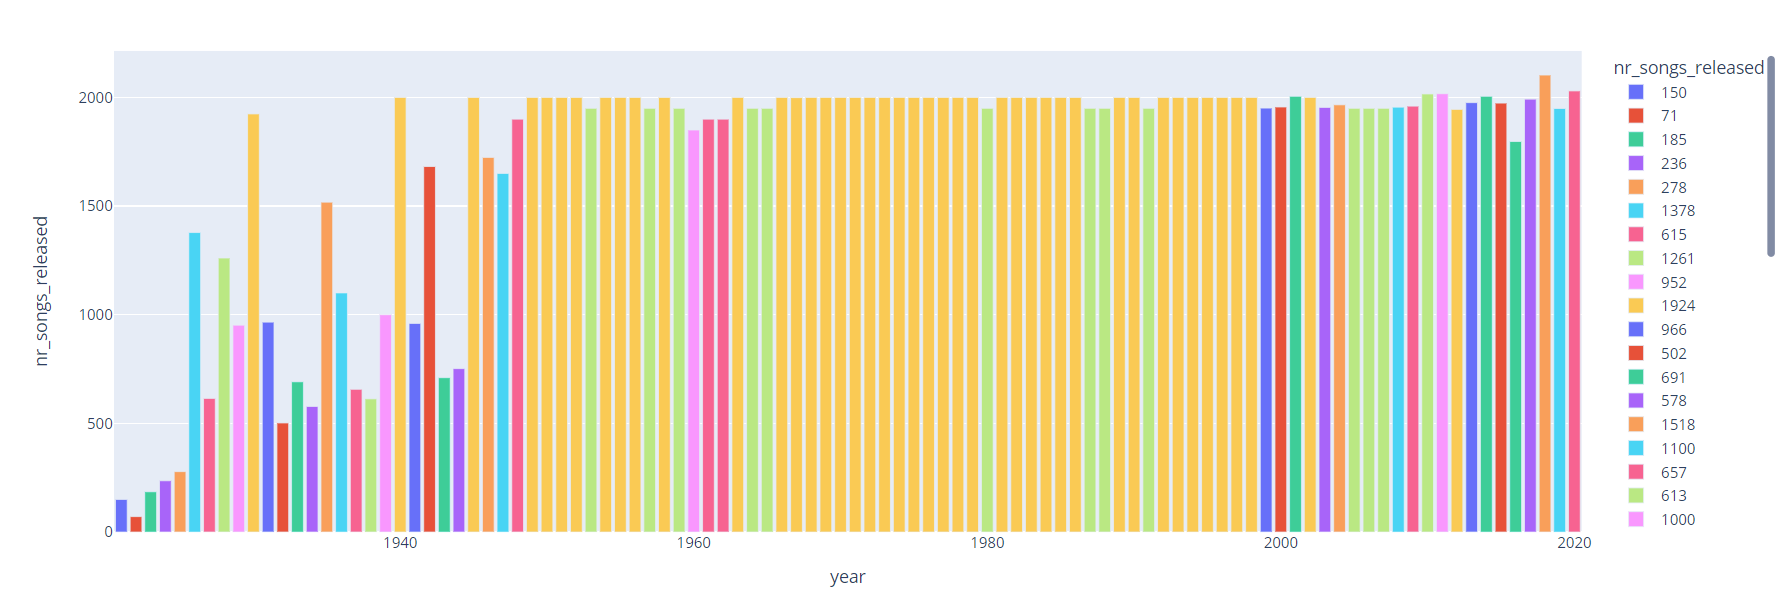

If we were to use this dataset in a machine learning problem, before training any model on the dataset it is good to check first the **correlation between the features** used in the training process.


For example, such a task could be to predict the popularity of a song based on the remained features from the dataset, as a result we are interested to see how correlated the popularity column is with the other columns.


This could help to further decide which columns from the dataset are important in the prediction task of the popularity, determing the columns used in the training process of the models.


For this matter we can build a **heatmap** matrix for a better visualization of the correlation between the features and some individual plots if we want to understand deeper the correlation between 2 specific features:

*   Correlation between all features using heatmap visualization approach
*   Correlation plot between *popularity* and *year* features
*   Correlation plot between *popularity* and *duration_seconds* features



In [37]:
data_shuffled = data.sample(frac=1)

From the following visualization of the correlatation matrix we can see that the 3 most correlated features with *popularity* are (all numbers represent the correlation coefficient based on Pearson formula):
*   year - 0.86
*   energy - 0.49
*   loudness - 0.46



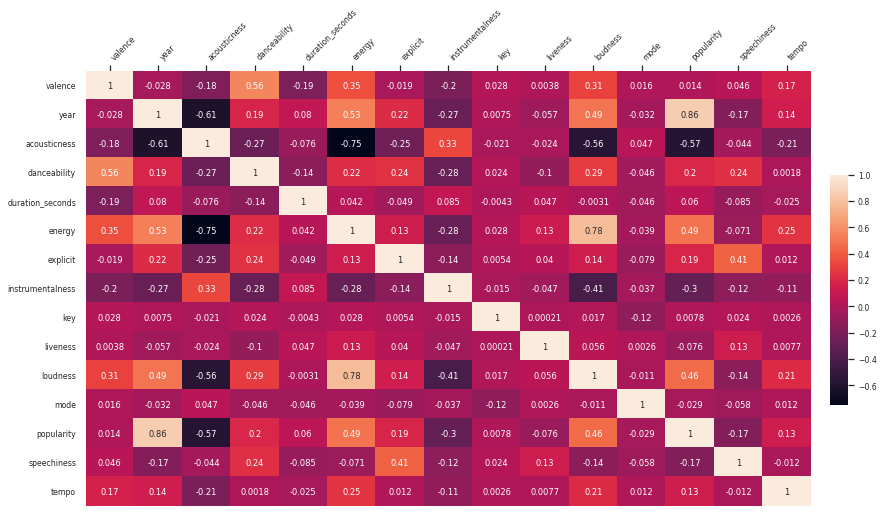

In [50]:
fig, ax = plt.subplots()
ax.xaxis.tick_top()
fig.set_size_inches(13, 8)
cbar_ax = fig.add_axes([.92, .3, .02, .4])
sb.set(font_scale=0.7)
heat_map = sb.heatmap(
    data_shuffled.corr(),
    ax=ax,
    cbar_ax=cbar_ax,
    xticklabels=data_shuffled.corr().columns,
    yticklabels=data_shuffled.corr().columns,
    annot=True
)
heat_map.set_xticklabels(
    heat_map.get_xticklabels(),
    rotation=45,
    horizontalalignment='left'
)
plt.show()

From the following illustrations we can observe that there is a *low* correlation between the *popuarity* and *duration_seconds* features and a *high* correlation between *popularity* and *year* features.

Text(0.5, 1.0, 'Popularity vs Release Year features correlation')

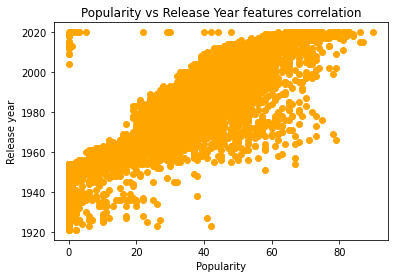

In [38]:
plt.scatter(data_shuffled['popularity'][:5000], data_shuffled['year'][:5000], c='orange')
plt.xlabel("Popularity")
plt.ylabel("Release year")
plt.title('Popularity vs Release Year features correlation')

Text(0.5, 1.0, 'Popularity vs Duration in seconds features correlation')

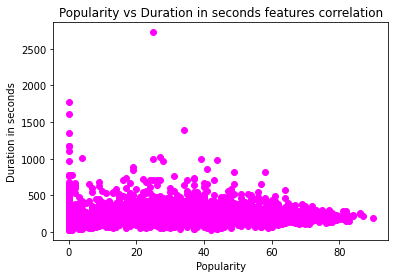

In [39]:
plt.scatter(data_shuffled['popularity'][:5000], data_shuffled['duration_seconds'][:5000], c='magenta')
plt.xlabel("Popularity")
plt.ylabel("Duration in seconds")
plt.title('Popularity vs Duration in seconds features correlation')